In [221]:
from os import rename
from os.path import split, join
from glob import glob
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import product
from IPython.display import display, HTML
pd.options.display.max_columns = 100
pd.options.display.max_rows = 10
sns.set_context("paper", font_scale=1.4)

# FHHPS Empirical Application

---

---

Reading data in (ignore).

In [235]:
dfs = []
for k, file in enumerate(glob(join("empirical_out", "*"))):
    df_tmp = pd.read_csv(file, header=None)
    dfs.append(df_tmp)
    
df = pd.concat(dfs).dropna()

In [236]:
mean_names = ["EA", "EB", "EC"]
cov_names = ["VarA", "VarB", "VarC", "CovAB", "CovAC", "CovBC"]
param_names = ["shock_bw1_const", "output_bw1_coqnst_step1", "output_bw1_const_step2", "output_bw2_const"]
pretty_param_names = ["$c_{shock}$", "$c_{y,1}^{(1)}$", "$c_{y,1}^{(2)}$", "$c_{y,2}$"]

In [237]:
params = ['n', 'kernel1', 'kernel2', 
      'output_bw1_const_step1', 'output_bw1_const_step2', 'output_bw2_const',
      'output_bw1_alpha', 'output_bw2_alpha', 
      'shock_bw1_const', 'shock_bw2_const', 'shock_bw1_alpha', 'shock_bw2_alpha', 
      'censor1_const', 'censor2_const']
others = ['mean_valid', 'cov_valid',"time"]
cols = params + others
df.columns = cols + mean_names + cov_names

Number of unique parameter combinations

In [238]:
f"we tried {len(df[params].drop_duplicates())} different tuning parameter combinations"

'we tried 10873 different tuning parameter combinations'

In [239]:
df.head()

,n,kernel1,kernel2,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,censor1_const,censor2_const,mean_valid,cov_valid,time,EA,EB,EC,VarA,VarB,VarC,CovAB,CovAC,CovBC
0,10566,neighbor,neighbor,0.05,0.50,0.5,0.1,0.1,0.50,0.01,0.166667,0.166667,2.00,1.0,0.547700,0.075052,340.906367,0.813085,-0.063209,0.048326,414.991230,-2.261096,-0.501758,6.134993,2.060169,0.046381
1,10566,gaussian,neighbor,0.01,0.01,0.1,0.1,0.1,0.50,0.10,0.166667,0.166667,0.10,0.1,0.960912,0.143006,284.953218,-0.603377,0.063416,0.004558,1227.788216,-6.376166,9.896932,110.184248,-173.940996,-0.071846
2,10566,neighbor,neighbor,0.05,0.10,0.5,0.1,0.1,0.01,0.10,0.166667,0.166667,0.01,2.0,0.996025,0.061140,320.279326,18.264158,-1.097549,0.156139,195907.098562,445.431232,258.907981,-7581.074426,-3303.624866,-41.458707
3,10566,neighbor,neighbor,0.10,0.10,0.5,0.1,0.1,0.01,0.10,0.166667,0.166667,0.50,1.0,0.831157,0.075052,324.899918,5.204368,-0.371331,0.101395,232543.165379,563.986865,246.681926,-9740.485715,-3022.063734,-47.209784
6,10566,gaussian,gaussian,0.05,0.05,0.5,0.1,0.1,0.10,0.50,0.166667,0.166667,1.00,0.5,0.706890,0.093034,310.204473,-0.825707,0.021682,0.059695,1396.056173,2.158701,7.461759,-20.337408,-94.629986,-0.187075


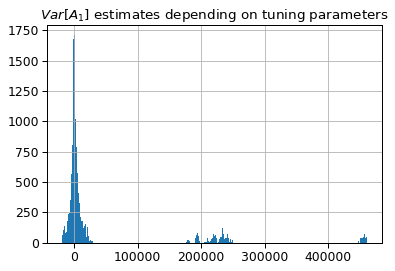

In [240]:
ax = df["VarA"].hist(bins=300)
ax.set_title("$Var[A_{1}]$ estimates depending on tuning parameters");

In [241]:
df[df["VarA"] > 100000][params].agg(["min", "mean", "median", "max"])

,n,kernel1,kernel2,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,censor1_const,censor2_const
min,10566.0,neighbor,gaussian,0.01000,0.01000,0.01000,0.1,0.1,0.01,0.010000,0.166667,0.166667,0.010000,0.010000
mean,10566.0,NaN,NaN,0.17443,0.17561,0.19982,0.1,0.1,0.01,0.165811,0.166667,0.166667,0.718286,0.745677
median,10566.0,NaN,NaN,0.10000,0.10000,0.10000,0.1,0.1,0.01,0.100000,0.166667,0.166667,0.500000,0.500000
max,10566.0,neighbor,neighbor,0.50000,0.50000,0.50000,0.1,0.1,0.01,0.500000,0.166667,0.166667,2.000000,2.000000


In [244]:
df[(df["VarA"] < 100) & (df["VarA"] > 0)][params]#.agg(["min", "mean", "median", "max"])

,n,kernel1,kernel2,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,censor1_const,censor2_const
16,10566,neighbor,neighbor,0.50,0.01,0.50,0.1,0.1,0.50,0.01,0.166667,0.166667,0.1,2.00
5,10566,gaussian,neighbor,0.50,0.01,0.50,0.1,0.1,0.50,0.50,0.166667,0.166667,0.1,2.00
12,10566,gaussian,gaussian,0.05,0.05,0.10,0.1,0.1,0.05,0.10,0.166667,0.166667,2.0,0.01
0,10566,gaussian,gaussian,0.10,0.10,0.50,0.1,0.1,0.50,0.10,0.166667,0.166667,0.5,1.00
2,10566,neighbor,neighbor,0.05,0.05,0.05,0.1,0.1,0.10,0.05,0.166667,0.166667,0.5,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,10566,neighbor,neighbor,0.10,0.05,0.05,0.1,0.1,0.10,0.10,0.166667,0.166667,0.5,2.00
10,10566,neighbor,neighbor,0.50,0.50,0.10,0.1,0.1,0.10,0.01,0.166667,0.166667,0.1,2.00
8,10566,gaussian,gaussian,0.50,0.10,0.10,0.1,0.1,0.50,0.05,0.166667,0.166667,1.0,1.00
8,10566,neighbor,neighbor,0.50,0.05,0.10,0.1,0.1,0.10,0.01,0.166667,0.166667,1.0,2.00


In [202]:
df_good = df[
    
    # Variances are positive
    (df["VarA"] > 0) & (df["VarB"] > 0)  & (df["VarC"] > 0) 
    
    # Variances have reasonable magnitude
    & (df["VarA"] < 100) & (np.abs(df["CovAB"]) < 20)  & (np.abs(df["CovAC"]) < 20) 

    # Correlations are smaller than 1
    & (np.abs(df["CovAC"]) < np.sqrt(df["VarA"]*df["VarC"]))
    & (np.abs(df["CovAB"]) < np.sqrt(df["VarA"]*df["VarB"]))
    & (np.abs(df["CovBC"]) < np.sqrt(df["VarB"]*df["VarC"]))
    
].drop_duplicates()

/Users/vitorh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


There are no observations satisfying all the criteria above

In [204]:
df_good

,n,kernel1,kernel2,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,censor1_const,censor2_const,mean_valid,cov_valid,time,EA,EB,EC,VarA,VarB,VarC,CovAB,CovAC,CovBC
